# This notebook must be run with the scvi conda environment within the scvi.sif singularity container

In [1]:
# scVI and scANVI Integration of Data
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import anndata as ad

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Whole brain atlas of the adolescent mouse brain was downloaded from this endpoint: http://mousebrain.org/adolescent/downloads.html

In [2]:
# first must convert the .loom file to a .h5ad for future use
base_path = '/hpc/projects/group.quake/doug/UCE/data/'
file_name = 'l5_all.loom'
output_name = 'l5_all.h5ad'
#l5_brain = sc.read_loom(base_path+file_name)
#l5_brain.obs['celltype'] = l5_brain.obs.Taxonomy_group
#l5_brain.write_h5ad(base_path+output_name)

In [3]:
whole = sc.read_h5ad(base_path+output_name)
whole.obs['batch'] = whole.obs.DonorID

#merged_ad_vize just see what happens if we subset to highly variable
whole.layers['counts'] = whole.X

#merged_ad_viz = merged_ad_viz[:, merged_ad_viz.var.highly_variable]
sc.pp.normalize_total(whole)
sc.pp.log1p(whole)
sc.pp.highly_variable_genes(whole, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.neighbors(whole)
sc.tl.umap(whole)

ad_viz = sc.read_h5ad('../preprocessing/baysor_segmented_6-5_micron.h5ad')

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 27998 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
genes_Vizgen = ad_viz.var.index
genes_10x = whole.var.index
genes_shared = genes_Vizgen.intersection(genes_10x) # List of shared genes

ad_viz = ad_viz[:, genes_Vizgen.isin(genes_shared)].copy()
whole = whole[:, genes_10x.isin(genes_shared)]

ad_viz.obs['tech']='Vizgen'
whole.obs['tech']='10x'

ad_viz.obs_names_make_unique()
whole.obs_names_make_unique()
ad_viz.var_names_make_unique()
whole.var_names_make_unique()

/tmp/ipykernel_1661375/2516862689.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  whole.obs['tech']='10x'
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them

In [5]:
brain_concat = ad.concat([whole, ad_viz], join='outer', label='tech', keys=['10x', 'Vizgen'])

# Use the annotations from the 10x, and treat the MERFISH as unlabeled
brain_concat.obs['celltype_scanvi'] = 'Unknown'
brain_10x_mask = brain_concat.obs['tech'] == '10x'

brain_concat.obs['celltype_scanvi'][brain_10x_mask] = brain_concat.obs[
    'celltype'][brain_10x_mask].values


# Create the scVI latent space
scvi.model.SCVI.setup_anndata(brain_concat, layer="counts", batch_key="tech")
vae_brain = scvi.model.SCVI(brain_concat)

# Train the brain model
vae_brain.train()

/tmp/ipykernel_1661375/1031685065.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  brain_concat.obs['celltype_scanvi'][brain_10x_mask] = brain_concat.obs[
/tmp/ipykernel_1661375/1031685065.py:7: SettingWithCopyWarning: 
A value is trying 

Epoch 1/7:   0%|          | 0/7 [00:00<?, ?it/s]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/7:  14%|█▍        | 1/7 [00:59<05:57, 59.63s/it, v_num=1, train_loss_step=89.1, train_loss_epoch=102]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/7:  29%|██▊       | 2/7 [01:51<04:36, 55.29s/it, v_num=1, train_loss_step=96.7, train_loss_epoch=99.1]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/7:  43%|████▎     | 3/7 [02:44<03:35, 53.88s/it, v_num=1, train_loss_step=100, train_loss_epoch=98.8] 

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/7:  57%|█████▋    | 4/7 [03:36<02:39, 53.21s/it, v_num=1, train_loss_step=97.3, train_loss_epoch=98.7]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/7:  71%|███████▏  | 5/7 [04:28<01:45, 52.80s/it, v_num=1, train_loss_step=103, train_loss_epoch=98.6] 

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/7:  86%|████████▌ | 6/7 [05:20<00:52, 52.55s/it, v_num=1, train_loss_step=86.8, train_loss_epoch=98.6]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/7: 100%|██████████| 7/7 [06:12<00:00, 52.36s/it, v_num=1, train_loss_step=100, train_loss_epoch=98.6] 

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 7/7: 100%|██████████| 7/7 [06:12<00:00, 53.20s/it, v_num=1, train_loss_step=100, train_loss_epoch=98.6]


In [6]:
# Register the object and run scANVI
scvi.model.SCANVI.setup_anndata(
    brain_concat,
    layer="counts",
    batch_key="tech",
    labels_key="celltype_scanvi",
    unlabeled_category="celltype"
)


lvae_brain = scvi.model.SCANVI.from_scvi_model(vae_brain, "Unknown", adata=brain_concat,labels_key="celltype_scanvi")

lvae_brain.train(max_epochs=20, n_samples_per_label=100)

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Training for 20 epochs.                                                                                   


/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/model/_scanvi.py:139: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=99` in the `DataLoader` to improve performance.


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/20:   5%|▌         | 1/20 [02:08<40:35, 128.17s/it, v_num=1, train_loss_step=102, train_loss_epoch=96.1]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 3/20:  10%|█         | 2/20 [04:15<38:22, 127.94s/it, v_num=1, train_loss_step=92.6, train_loss_epoch=90.9]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 4/20:  15%|█▌        | 3/20 [06:19<35:44, 126.13s/it, v_num=1, train_loss_step=91.1, train_loss_epoch=90.5]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 5/20:  20%|██        | 4/20 [08:29<34:02, 127.63s/it, v_num=1, train_loss_step=86.2, train_loss_epoch=90.4]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 6/20:  25%|██▌       | 5/20 [10:46<32:41, 130.77s/it, v_num=1, train_loss_step=89.5, train_loss_epoch=90.3]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 7/20:  30%|███       | 6/20 [13:03<31:02, 133.03s/it, v_num=1, train_loss_step=85, train_loss_epoch=90.2]  

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 8/20:  35%|███▌      | 7/20 [15:20<29:04, 134.22s/it, v_num=1, train_loss_step=84.6, train_loss_epoch=90.2]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 9/20:  40%|████      | 8/20 [17:37<27:00, 135.01s/it, v_num=1, train_loss_step=92.2, train_loss_epoch=90.1]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 10/20:  45%|████▌     | 9/20 [19:53<24:50, 135.51s/it, v_num=1, train_loss_step=85.8, train_loss_epoch=90] 

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 11/20:  50%|█████     | 10/20 [22:10<22:38, 135.85s/it, v_num=1, train_loss_step=89.9, train_loss_epoch=89.8]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 12/20:  55%|█████▌    | 11/20 [24:27<20:25, 136.14s/it, v_num=1, train_loss_step=95.1, train_loss_epoch=89.6]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 13/20:  60%|██████    | 12/20 [26:44<18:12, 136.57s/it, v_num=1, train_loss_step=92.1, train_loss_epoch=89.6]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 14/20:  65%|██████▌   | 13/20 [28:54<15:41, 134.50s/it, v_num=1, train_loss_step=91.1, train_loss_epoch=89.6]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 15/20:  70%|███████   | 14/20 [31:00<13:11, 131.94s/it, v_num=1, train_loss_step=89.2, train_loss_epoch=89.5]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 16/20:  75%|███████▌  | 15/20 [33:06<10:50, 130.19s/it, v_num=1, train_loss_step=81.1, train_loss_epoch=89.6]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 17/20:  80%|████████  | 16/20 [35:12<08:35, 128.96s/it, v_num=1, train_loss_step=88.5, train_loss_epoch=89.6]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 18/20:  85%|████████▌ | 17/20 [37:18<06:24, 128.12s/it, v_num=1, train_loss_step=90, train_loss_epoch=89.6]  

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 19/20:  90%|█████████ | 18/20 [39:24<04:14, 127.49s/it, v_num=1, train_loss_step=91.4, train_loss_epoch=89.7]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 20/20:  95%|█████████▌| 19/20 [41:30<02:07, 127.10s/it, v_num=1, train_loss_step=98.7, train_loss_epoch=89.8]

/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
/home/doug.henze/.conda/envs/scvi/lib/python3.9/site-packages/scvi/module/_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 20/20: 100%|██████████| 20/20 [43:37<00:00, 126.83s/it, v_num=1, train_loss_step=99.4, train_loss_epoch=89.9]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [43:37<00:00, 130.86s/it, v_num=1, train_loss_step=99.4, train_loss_epoch=89.9]


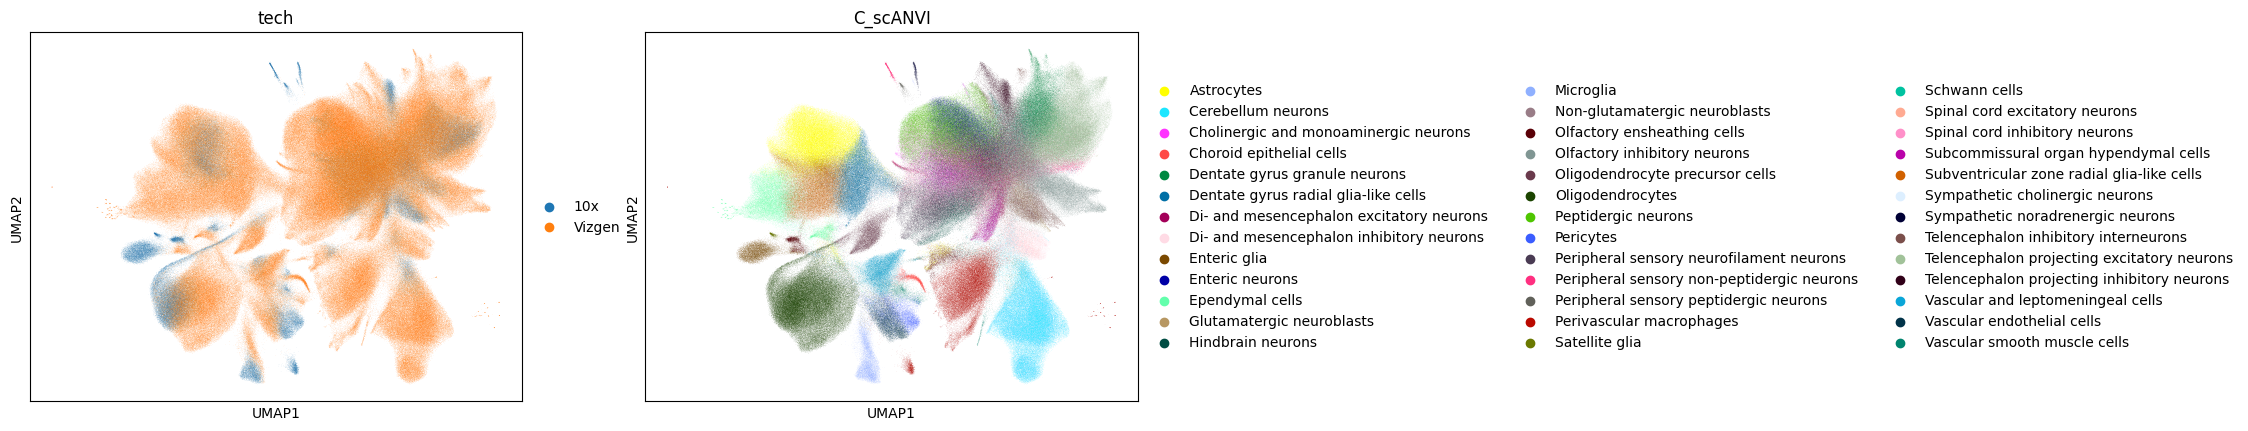

In [7]:
# Get the predicted annotations and latent representation
brain_concat.obs["C_scANVI"] = lvae_brain.predict(brain_concat)
brain_concat.obsm["X_scANVI"] = lvae_brain.get_latent_representation(brain_concat)

# Calculate the UMAP in the joint latent space
sc.pp.neighbors(brain_concat, use_rep="X_scANVI")
sc.tl.umap(brain_concat)

# Plot the joint UMAP
sc.pl.umap(brain_concat, color=['tech', 'C_scANVI'])

In [8]:
test = brain_concat[brain_concat.obs.tech == 'Vizgen']
test.obsm['spatial'] = test.obs[["x", "y"]].values
test.obs['celltype'] = test.obs.C_scANVI

/tmp/ipykernel_1661375/3625519199.py:2: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  test.obsm['spatial'] = test.obs[["x", "y"]].values


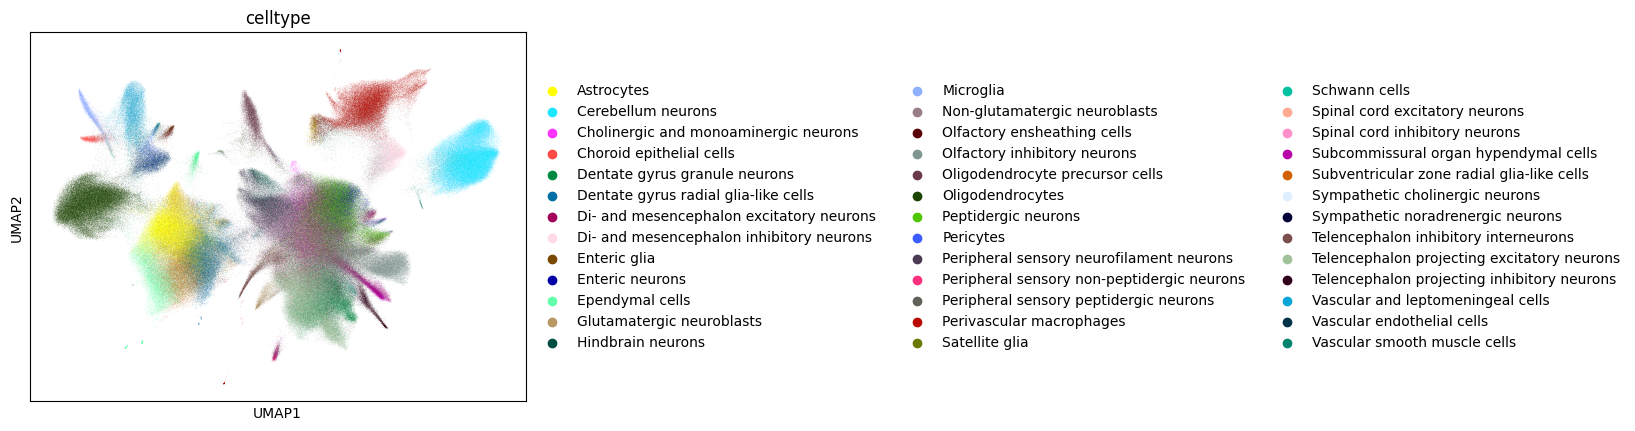

In [10]:
sc.pp.neighbors(test)
sc.tl.umap(test)
#sc.tl.leiden(test,resolution=1)
# Plot the joint UMAP
sc.pl.umap(test, color=['celltype'])

test.write_h5ad('full_dataset_SCANVI.h5ad')